# Examples of how to run Barry for DESI KP4
This notebook demonstrates how to use Barry with the KP4 data. 

The data gets pre-processed into a set of 'pickle' files that contain everything Barry needs in the notebook `/barry/data/desi_kp4/pickle_desi_kp4.py`. After running this, you should have the following set of 11 files in `/barry/data/`

* `desi_kp4_abacus_cubicbox_{xi/pk}_lrg.pkl`
* `desi_kp4_abacus_cutsky_{xi/pk}_lrg_zmin{0.4/0.6/0.8}_zmax{0.6/0.8/1.1}.pkl`
* `desi_kp4_ezmock_cutsky_{xi/pk}_lrg_zmin{0.4/0.6/0.8}_zmax{0.6/0.8/1.1}.pkl`

I anticipate there being more as we introduce more tracers etc., but the code for producing them should be extendable easily enough. This notebook covers the details of how these get read in, how to make some plots with them, and how to run some simple optimisations and sanity checks with different models.

## Reading in the data
I've already created classes for the KP4 data. You can find them in `/barry/datasets/dataset_power_spectrum.py` and `/barry/dataset/dataset_correlation_function.py`. These are currently coded up to only read in the LRG samples above, but again can be extended easily enough for other tracers.

The way you get the data is by instantiating the class, with an appropriate set of arguments. Some of these arguments determine how the data will be treated. The others tell the code which of the files above to read in. The full set of (accessible) arguments for the power spectrum is:

* `min_k`: The minimum k-value to consider. Default is 0.02
* `max_k`: The maximum k-value to consider. Default is 0.30
* `recon`: Whether to use pre- or post-reconstruction data. Choices are `None`, "iso", "ani" or "sym", but only `None` is currently implemented. Default is `None`
* `reduce_cov_factor`: Factor to divide the covariance matrix by. Default is 1.0
* `realisation`: The realisation to load. Choices are "data", `None` (mock mean), or an integer (mock realisation). Default is `None`.
* `fit_poles`: A list of multipoles to consider in the fitting. Default is `(0,)`.
* `mocktype`: Which KP4 mocks to load. Choices are "abacus_cubicbox", "abacus_cutsky", "ezmock_cutsky". Default is "abacus_cubicbox".
* `tracer`: Which tracer to load. Only "lrg" is currently implemented, which is the default.
* `redshift_bin`: Which redshift bin to load. Choices change based on `tracer` and `mocktype`. Default is 1.
    * `tracer=lrg`.
        * 1 for `mocktype="abacus_cubicbox"`. 
        * 1, 2 or 3 for `mocktype="abacus_cutsky"` or `mocktype="ezmock_cutsky"`.
        
The arguments are the same for the correlation function, except for `min_dist` and `max_dist` instead of `min_k` and `max_k`.
        
The only real relevant functions for the class are:
* `get_data()`: Return a list of dictionaries for the data
* `set_realisation()`: Useful for changing the realisation you are using without re-initialising the class.

Let's try these out and plot some data

In [1]:
from barry.datasets.dataset_power_spectrum import PowerSpectrum_DESI_KP4
from barry.datasets.dataset_correlation_function import CorrelationFunction_DESI_KP4

# Lets read in a single instance of the data and have a look
dataset = PowerSpectrum_DESI_KP4()
data = dataset.get_data()[0]
print(data)

# Lets read in a single instance of the data and have a look
dataset = CorrelationFunction_DESI_KP4()
data = dataset.get_data()[0]
print(data)

ERROR, setting an inappropriate covariance matrix that is almost singular!!!!
These should all be 1: [-0.59471575  0.84793478  0.81871585 -1.91185003  0.75961909  0.73513373
  1.19592311  1.50717469 -0.37275507  0.79288458  1.55340738  0.59786316
  1.08475302  0.14300799  0.65356764  1.15538537 -1.42332222  0.95780064
 -0.18353822  0.96384391  1.94935807  0.78348292  0.57821961 -0.17437426
  1.16621062  2.18685699  0.83798793  1.84332991  1.43018984  2.10958514
  1.32436294  0.55238938  1.37843369 -2.20578452  1.35291173 -0.02534712
  0.05690177  1.33190352  0.30726853 -0.19793976  0.35363679  2.24324115
  0.83919465  0.98550714  2.07716285  0.22247984  0.1994087   0.11280431
 -1.01478952  0.48223013  0.49642753  1.87666551 -0.7884401   1.63034897
  0.24251123  2.00056995]
ERROR, setting an inappropriate covariance matrix that is almost singular!!!!
These should all be 1: [-5.46064962e+00  5.18958616e+00 -1.03856018e+01 -6.39720672e+01
 -3.87821998e+00 -7.07232974e+00  3.54802316e+01  

{'ndata': 1, 'ks_output': array([0.00633346, 0.01115251, 0.01561439, 0.02061503, 0.0256136 ,
       0.03072057, 0.0357475 , 0.04067656, 0.04565162, 0.05052291,
       0.05547455, 0.06052756, 0.06558141, 0.07055631, 0.07553948,
       0.08057221, 0.08554966, 0.09054611, 0.09556397, 0.10054689,
       0.10556233, 0.11054428, 0.11552747, 0.12053836, 0.12552864,
       0.13051951, 0.1355129 , 0.14053037, 0.14555919, 0.15054331,
       0.15553749, 0.16052434, 0.16551958, 0.17051437, 0.17552089,
       0.18052541, 0.18551665, 0.19055827, 0.19554067, 0.20051072,
       0.20551453, 0.21050442, 0.21552038, 0.22052263, 0.22553618,
       0.23052787, 0.23552018, 0.24053589, 0.24553289, 0.25053114,
       0.25551973, 0.26049817, 0.26550466, 0.2705156 , 0.27552982,
       0.28052907, 0.2854988 , 0.29051108, 0.29552011, 0.30052332,
       0.30552345, 0.31051521, 0.31552224, 0.32051578, 0.32551838,
       0.33050949, 0.33551545, 0.34051153, 0.34551154, 0.35051287,
       0.35548719, 0.36050842, 0.365

This prints out a lot of information about the dataset! Most of it is just useful for the fitting (i.e., window functions, inverse covariance matrices, masking the appropriate fitting ranges), but we might want to access some of it directly. For instance, we can plot the data using the "ks", "cov" and "pk0", "pk2", "pk4" entries. For correlation function we can use "s", "cov", "xi0", "xi2" and "xi4". The "num_mocks" entry and "cosmology" (the fiducial cosmology) might be useful too.

ERROR, setting an inappropriate covariance matrix that is almost singular!!!!
These should all be 1: [-0.59471575  0.84793478  0.81871585 -1.91185003  0.75961909  0.73513373
  1.19592311  1.50717469 -0.37275507  0.79288458  1.55340738  0.59786316
  1.08475302  0.14300799  0.65356764  1.15538537 -1.42332222  0.95780064
 -0.18353822  0.96384391  1.94935807  0.78348292  0.57821961 -0.17437426
  1.16621062  2.18685699  0.83798793  1.84332991  1.43018984  2.10958514
  1.32436294  0.55238938  1.37843369 -2.20578452  1.35291173 -0.02534712
  0.05690177  1.33190352  0.30726853 -0.19793976  0.35363679  2.24324115
  0.83919465  0.98550714  2.07716285  0.22247984  0.1994087   0.11280431
 -1.01478952  0.48223013  0.49642753  1.87666551 -0.7884401   1.63034897
  0.24251123  2.00056995]


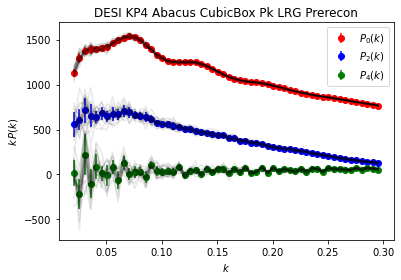

ERROR, setting an inappropriate covariance matrix that is almost singular!!!!
These should all be 1: [-5.46064962e+00  5.18958616e+00 -1.03856018e+01 -6.39720672e+01
 -3.87821998e+00 -7.07232974e+00  3.54802316e+01  4.36877947e+01
 -1.41857414e+02 -2.11973849e+01 -3.68209689e+00  1.22164872e+02
  4.64752132e+00  7.86213453e+01  1.34060175e+02  1.51705569e+01
 -2.82695143e+01 -8.54266309e+00  1.27425653e+02  6.91531241e+01
  3.84007391e+01 -3.28641916e+01 -2.83496221e+01 -8.08706361e+01
  3.17803516e+02  1.56557447e+02 -2.99264866e+01  4.47285387e+01
  1.57747658e+01 -3.09182259e+01 -2.04514592e+01 -9.87029462e+01
  1.70378727e+01 -7.80945501e-01 -7.67907822e+00  1.52718061e-01
  3.68186052e+01 -4.30678439e+01 -1.54155648e+01  3.68066456e+01
 -4.67957486e+01 -9.48651789e+01 -2.18169437e+01]


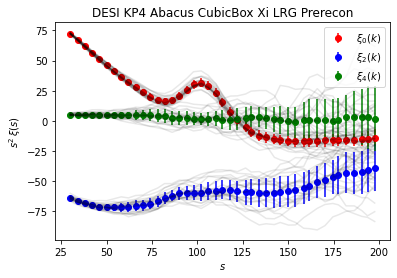

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def plot_pk(dataset):
    
    color = ["r", "b", "g"]
    label = [r"$P_{0}(k)$", r"$P_{2}(k)$", r"$P_{4}(k)$"]
    
    # Plot some pk data
    for m, pk in enumerate(["pk0", "pk2", "pk4"]):
        dataset.set_realisation(None) # Sets the data to the mock mean.
        data = dataset.get_data()[0]
        ks, err = data["ks"], np.sqrt(np.diag(data["cov"]))
        yerr = ks * err[2 * m * len(ks) : (2 * m + 1) * len(ks)]
        plt.errorbar(
            ks,
            ks * data[pk][0],
            yerr=yerr,
            marker="o",
            ls="None",
            c=color[m],
            label=label[m],
        )
        for i in range(data["num_mocks"]):
            dataset.set_realisation(i)  # Changes the realisation to one of the mocks, and plots that.
            data = dataset.get_data()[0]
            plt.errorbar(ks, ks * data[pk][0], marker="None", ls="-", c="k", alpha=1.0 / data["num_mocks"]**(3.0/4.0))
    plt.xlabel(r"$k$")
    plt.ylabel(r"$k\,P(k)$")
    plt.title(dataset.name)
    plt.legend()
    plt.show()
    
def plot_xi(dataset):
    
    color = ["r", "b", "g"]
    label = [r"$\xi_{0}(k)$", r"$\xi_{2}(k)$", r"$\xi_{4}(k)$"]
    
    # Plot sxome xi data
    for m, xi in enumerate(["xi0", "xi2", "xi4"]):
        dataset.set_realisation(None) # Sets the data to the mock mean.
        data = dataset.get_data()[0]
        ss, err = data["dist"], np.sqrt(np.diag(data["cov"]))
        yerr = ss ** 2 * err[m * len(ss) : (m + 1) * len(ss)]
        plt.errorbar(
            ss,
            ss ** 2 * data[xi],
            yerr=yerr,
            marker="o",
            ls="None",
            c=color[m],
            label=label[m],
        )
        for i in range(data["num_mocks"]):
            dataset.set_realisation(i)  # Changes the realisation to one of the mocks, and plots that.
            data = dataset.get_data()[0]
            plt.errorbar(ss, ss ** 2 * data[xi], marker="None", ls="-", c='k', alpha=1.0 / data["num_mocks"]**(3.0/4.0))
    plt.xlabel(r"$s$")
    plt.ylabel(r"$s^{2}\,\xi(s)$")
    plt.title(dataset.name)
    plt.legend()
    plt.show()
    
dataset = PowerSpectrum_DESI_KP4()
plot_pk(dataset)

dataset = CorrelationFunction_DESI_KP4()
plot_xi(dataset)

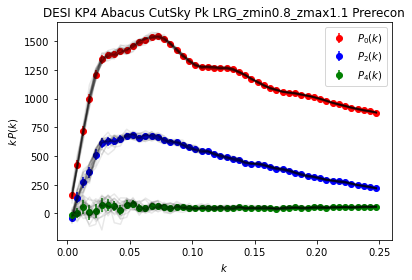

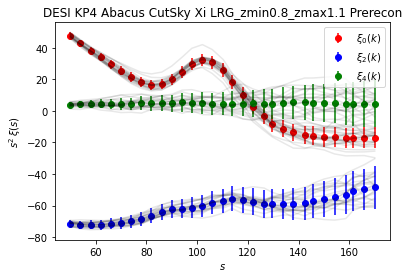

In [3]:
# Let's try a different k-range, mock type and redshift bin
dataset = PowerSpectrum_DESI_KP4(mocktype="abacus_cutsky", min_k=0.0, max_k=0.25, redshift_bin=3)
plot_pk(dataset)

# Let's try a different s-range, mock type and redshift bin
dataset = CorrelationFunction_DESI_KP4(mocktype="abacus_cutsky", min_dist=50.0, max_dist=170.0, redshift_bin=3)
plot_xi(dataset)

ERROR, setting an inappropriate covariance matrix that is almost singular!!!!
These should all be 1: [-1.09230674e+01  4.64027395e+00 -7.74599345e+00 -7.81587691e-01
  1.07687493e+00  1.71401636e+01  3.43084509e+00  8.62251802e+00
  9.62740263e-01 -3.01254552e+00  4.60423352e+00  6.26471649e-01
 -1.27094044e+01  1.27876205e+00  5.72715619e+00 -3.20228281e+00
  5.86814737e+00  1.05475970e+00 -1.22690770e+00 -1.02585586e+00
  4.22952090e+00  2.57995267e+00  7.21884019e+00 -3.27518797e+00
  6.13433365e+00  3.56283655e+00 -4.10034654e+00  3.96343308e-01
  1.58658146e+00  4.59677574e-01 -9.49154465e-01  6.91135917e-02
  8.18699838e+00 -5.62861302e-01  7.37630896e+00  2.56531980e-01
  1.25498851e+00 -4.28611866e+00  3.69594734e+00 -3.45596122e+00
 -1.18815262e+01  9.58444011e-01  3.67318611e+00  4.20311407e-02
  2.64366157e+00  4.13352208e-01 -9.80097000e-01 -3.33720133e+00
 -4.74914346e-01 -1.41295941e+00  7.38546346e+00 -3.44057060e+00
  2.34222980e+00  2.70357246e+00 -3.00566574e+00  4.10

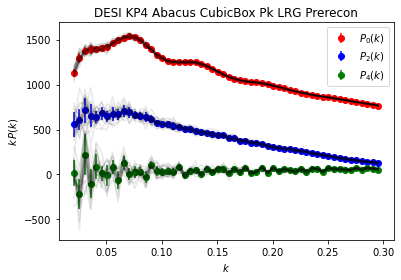

ERROR, setting an inappropriate covariance matrix that is almost singular!!!!
These should all be 1: [-0.12133149  2.02325289  0.60940472  1.08353288  1.66901509 -0.22229138
  0.56960609  2.13390162  0.49750504  1.98163106  0.09417316  1.02340352
  1.27149101  0.31446736 -0.45721873  1.48300748  2.57334876  0.56750382
 -1.54982409  0.6155464   0.54045162  0.26627459  2.23616242 -5.90511744
 -1.57825373 -2.43187362 -0.47369046 -0.46275935 -0.96859937  0.59236789
 -5.18324953 -0.81473906  3.25       -0.4667333  -2.44820254  2.94393333
 -1.06059656  0.90714178 -1.98074029 -0.98817727  0.62331305  0.94779959
  3.47224074  0.08716964  2.37767458  1.67578838 -1.96581243  1.08714145
  0.46407645  0.95781314  2.36164889  4.51296739  0.36432719 -1.10275039
 -0.65075914  0.41510035  0.20371253  1.33033388 -2.21142554  2.22022163
  0.46354449  2.38983926  0.42779213  0.65213756  0.04426892  0.27743837
  0.23474435  3.06575364 -0.65504331  1.93115177 -1.73484662 -1.99241265
 -1.5348439   1.4654839

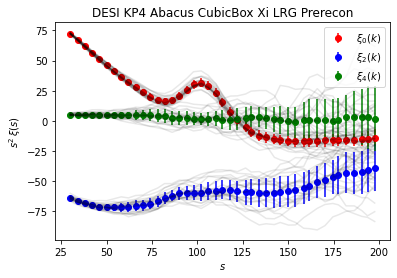

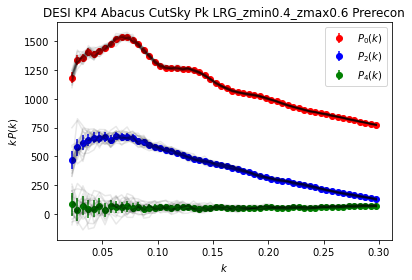

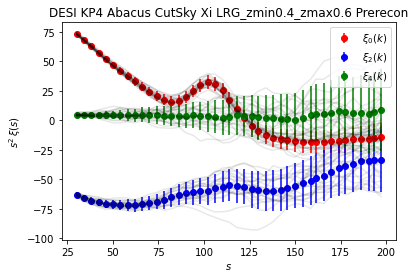

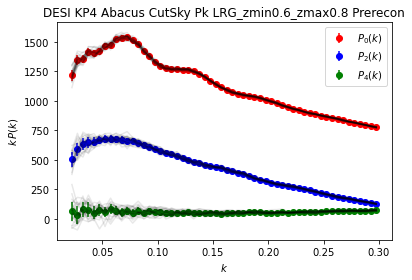

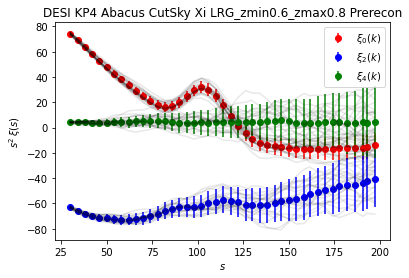

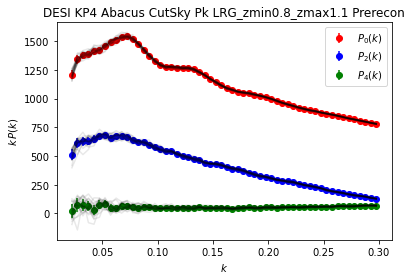

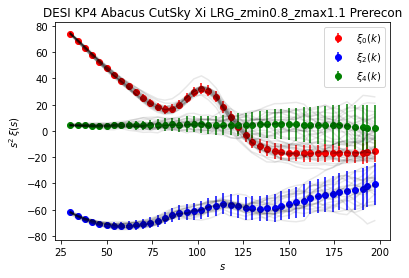

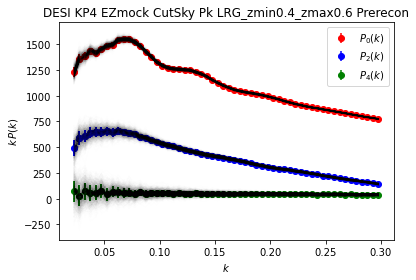

FileNotFoundError: [Errno 2] No such file or directory: '/global/u1/c/chowlett/Barry/barry/data/desi_kp4_ezmock_cutsky_xi_lrg_zmin0.4_zmax0.6.pkl'

In [4]:
# Let's try all the possible tracers, mocktypes and redshift bins
tracers = ["lrg", "lrg", "lrg"]
nzbins = [1, 3, 3]
mocktypes = ["abacus_cubicbox", "abacus_cutsky", "ezmock_cutsky"]
for j, (tracer, redshift_bins, mocktype) in enumerate(zip(tracers, nzbins, mocktypes)):
    for z in range(redshift_bins):
        plot_pk(PowerSpectrum_DESI_KP4(
            recon=None,
            fit_poles=[0, 2, 4],
            min_k=0.02,
            max_k=0.30,
            mocktype=mocktype,
            tracer=tracer,
            redshift_bin=z + 1,
            realisation=None,
        ))
        plot_xi(CorrelationFunction_DESI_KP4(
            recon=None,
            fit_poles=[0, 2, 4],
            min_dist=30.0,
            max_dist=200.0,
            mocktype=mocktype,
            tracer=tracer,
            redshift_bin=z + 1,
            realisation=None,
        ))

# Models
Okay. Now we have a handle on the datasets, and how to load them in, let's see about running a fit. The first thing we need to do is choose a model. Barry currently has the following options:
* `bao_power_Beutler2017`: Model as in Beutler et. al., 2017 with free damping parameters
* `bao_power_Chen2019`: Model as in Chen et. al., 2019 with Zeldovich approximation based BAO damping
* `bao_power_Ding2018`: Model as in Ding et. al., 2018 with EFT-based model
* `bao_power_Seo2016`: Model as in Seo et. al., 2016 with LPT inspired BAO damping.
* `bao_correlation_Beutler2017`: Correlation function transformation applied to Beutler et. al., 2017 power spectrum with free damping parameters
* `bao_power_Ding2018`: Correlation function transformation applied to Ding et. al., 2018 power spectrum with EFT-based model
* `bao_power_Seo2016`: Correlation function transformation applied to Seo et. al., 2016 power spectrum with LPT inspired BAO damping.

Each of these also has different free parameters that can be allowed to vary or be fixed. Power spectra support 0, 3 or 5 polynomial terms added to each multipole, correlation function is currently just 3. 

The models work as classes, and have the following (relevant) keyword arguments:
* `fix_params`: A list of parameters to fix in the model.
* `recon`: A reconstruction convention, same options as for data. Easiest to set as recon=dataset.recon.
* `smooth`: Whether to return a model with (`False`) or without (`True`) BAO wiggles. Default is `True`.
* `correction:` A correction to use for the likelihood to account for the errors in the covariance matrix. Corrections are also classes, but typically we'll want Correction.NONE, Correction.HARTLAP or Correction.SELLENTIN.
* `isotropic`: Whether to fit for only alpha, or for alpha and epsilon.
* `poly_poles`: Which multipoles to add polynomial terms to.
* `marg`: Whether to speed things up by analytically marginalising over linear order broadband terms. Options are `None`, "full" (proper Bayesian marginalisation) or "partial" (find the best-fit polynomial terms at each point in the MCMC chain).
* `dilate_smooth`: For the Beutler 2017 power spectrum model only, whether to dilate only the wiggles of the model (`False`), or the whole model (`True`), by the BAO dilation parameters. Default is True.
* `n_poly`: Only for power spectrum. The number of polynomial terms per multipole. Default is 5.

So lets have a look at creating and plotting some models! Useful functions are:
* `get_defaults()`: Return a set of default parameter values.
* `set_default(param, value)`: Update the default value for a parameter.
* `get_param_dict(params)`: Set the values of the parameters to the values in params and return a dictionary.
* `set_cosmology(cosmo)`: Set the template cosmology given a dictionary of cosmology parameters.
* `compute_power_spectrum(k, param_dict)`: Compute the model for a dictionary of parameter values.
* `set_data(dataset)`: Set the model up to return a prediction for some data. Set's up the template cosmology to the fiducial cosmology of the data, organises the k-binning and window function convolution for you.

In [5]:
from barry.models.bao_power_Beutler2017 import PowerBeutler2017

# Instantiate a model.
model_iso = PowerBeutler2017(isotropic=True)
model_ani = PowerBeutler2017(isotropic=False)

# Get the default values of the model and also as a dictionary. You should see that the
# anisotropic model has a lot more polynomial terms and also separate BAO damping perpendicular and parallel
# to the line of sight. This is because it fits the multipoles, rather than just the monopole.
p_dict_iso = model_iso.get_param_dict(model_iso.get_defaults())
p_dict_ani = model_ani.get_param_dict(model_ani.get_defaults())
print(p_dict_iso, p_dict_ani)

# Let's see some other combos. Include polynomials for hexadecapole:
model = PowerBeutler2017(isotropic=False, poly_poles=(0,2,4)) 
# Fix the BAO damping parameters and beta=f/b to their default values:
model = PowerBeutler2017(isotropic=False, poly_poles=(0,2,4), fix_params=("sigma_nl_perp", "sigma_nl_par", "beta"))

# Update the default values of the sigma_nl's. The default is 4 and 8 for perp and par respectively.
# You can see these get updated to 5 and 11.
print(model.get_param_dict(model.get_defaults()))
model.set_default("sigma_nl_perp", 5.0)
model.set_default("sigma_nl_par", 11.0)
print(model.get_param_dict(model.get_defaults()))

OrderedDict([('alpha', 1.0), ('sigma_s', 10.0), ('sigma_nl', 10.0), ('a{0}_1_{1}', 0), ('a{0}_3_{1}', 0), ('om', 0.31), ('a{0}_5_{1}', 0), ('a{0}_2_{1}', 0), ('b_{1}', 1.0), ('a{0}_4_{1}', 0)]) OrderedDict([('alpha', 1.0), ('epsilon', 0.0), ('sigma_s', 10.0), ('beta', 0.5), ('sigma_nl_par', 8.0), ('sigma_nl_perp', 4.0), ('a{0}_1_{1}', 0), ('a{0}_3_{1}', 0), ('om', 0.31), ('a{2}_4_{1}', 0), ('a{2}_5_{1}', 0), ('a{0}_5_{1}', 0), ('a{0}_2_{1}', 0), ('a{2}_1_{1}', 0), ('a{2}_2_{1}', 0), ('a{2}_3_{1}', 0), ('b_{1}', 1.0), ('a{0}_4_{1}', 0)])
OrderedDict([('om', 0.31), ('alpha', 1.0), ('epsilon', 0.0), ('sigma_s', 10.0), ('a{4}_2_{1}', 0), ('a{0}_2_{1}', 0), ('sigma_nl_perp', 4.0), ('a{0}_4_{1}', 0), ('a{4}_4_{1}', 0), ('sigma_nl_par', 8.0), ('a{2}_3_{1}', 0), ('a{0}_1_{1}', 0), ('a{4}_1_{1}', 0), ('a{0}_3_{1}', 0), ('a{0}_5_{1}', 0), ('a{4}_5_{1}', 0), ('a{2}_1_{1}', 0), ('a{2}_2_{1}', 0), ('beta', 0.5), ('a{2}_4_{1}', 0), ('a{2}_5_{1}', 0), ('a{4}_3_{1}', 0), ('b_{1}', 1.0)])
OrderedDict([

To return the actual model prediction, we need to first tell the model what the template cosmology is, then compute it. We'll start with unmarginalised models, as these return the actual model, rather than components. For fitting purposes it's better to use `marg="full"`, but it's less interpretable what the model is doing

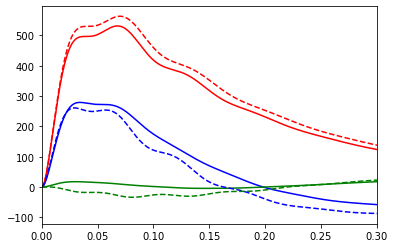

In [6]:
from barry.models.bao_power_Ding2018 import PowerDing2018

cosmology = {
            "om": 0.31,
            "h0": 0.67,
            "z":  0.51,
            "ob": 0.048,
            "ns": 0.97,
            "mnu": 0.0,
            "reconsmoothscale": 15,
        }
model = PowerDing2018(isotropic=False)
model.set_cosmology(cosmology)
ks = model.camb.ks

# This function returns the values of k'(k,mu), pk (technically only the unmarginalised terms)
# and model components for analytically marginalised parameters
p = model.get_param_dict(model.get_defaults())
kprime, pk, marged = model.compute_power_spectrum(ks, p)

# Plot the model multipoles
plt.errorbar(ks, ks * pk[0], marker="None", ls="-", c="r", label=r"$P_{0}(k)$")
plt.errorbar(ks, ks * pk[2], marker="None", ls="-", c="b", label=r"$P_{2}(k)$")
plt.errorbar(ks, ks * pk[4], marker="None", ls="-", c="g", label=r"$P_{4}(k)$")

# Update alpha and epsilon, and show a comparison
p["alpha"] = 1.05
p["epsilon"] = -0.04
kprime, pk_new, marged = model.compute_power_spectrum(ks, p)

# Plot the model multipoles
plt.errorbar(ks, ks * pk_new[0], marker="None", ls="--", c="r", label=r"$P_{0}(k)$")
plt.errorbar(ks, ks * pk_new[2], marker="None", ls="--", c="b", label=r"$P_{2}(k)$")
plt.errorbar(ks, ks * pk_new[4], marker="None", ls="--", c="g", label=r"$P_{4}(k)$")
plt.xlim(0.0, 0.3)
plt.show()

# Fitting the data
Okay, now let's do some proper fits. We first set the data, then we can run any fits we want

Starting model optimisation. This may take some time.
model_ding
alpha, epsilon: 1.0067487877387447 0.0006806212315351723
alpha_par, alpha_perp: (1.0081196833098638, 1.0060640391933857)
-------------


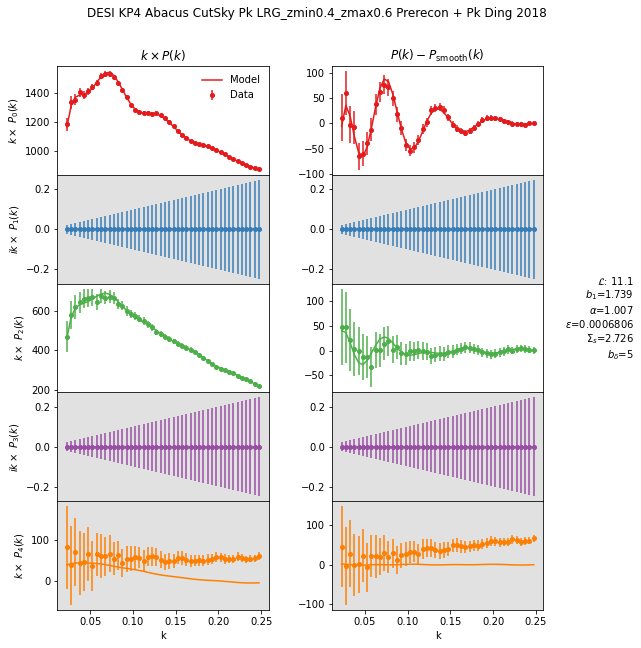

Starting model optimisation. This may take some time.
model_beutler
alpha, epsilon: 1.0058085688691705 0.0011921005958887565
alpha_par, alpha_perp: (1.0082080482161786, 1.0046109715313716)
-------------


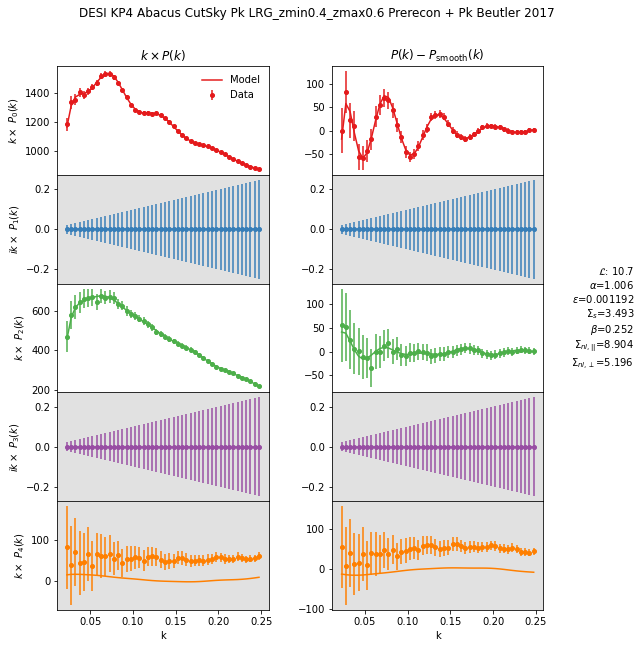

Starting model optimisation. This may take some time.
model_beutler_3poly
alpha, epsilon: 1.0055386041330079 0.0016380250610965041
alpha_par, alpha_perp: (1.0088354969868218, 1.0038942002742692)
-------------


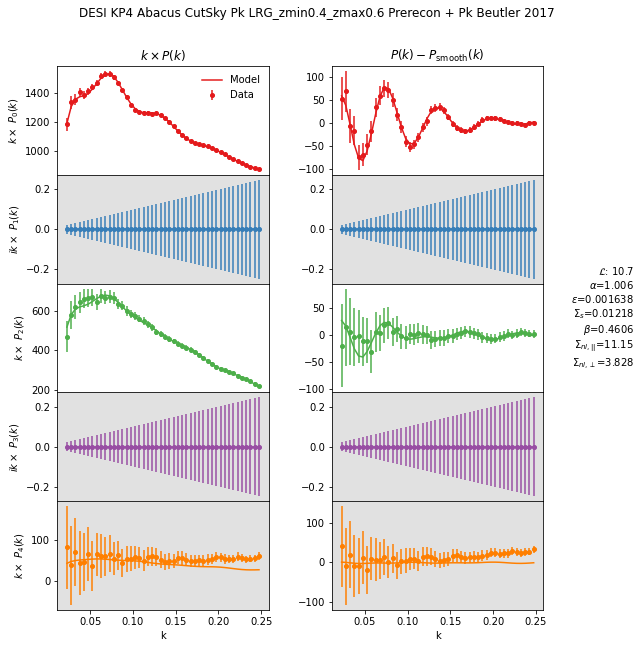

Starting model optimisation. This may take some time.


In [ ]:
# Load in the z=0.8-1.1 ezmock_cutsky dataset with and without the hexadecapole included in the fit
dataset = PowerSpectrum_DESI_KP4(mocktype="abacus_cutsky", fit_poles=(0,2), min_k=0.02, max_k=0.25, redshift_bin=1)
dataset_hexa = PowerSpectrum_DESI_KP4(mocktype="abacus_cutsky", fit_poles=(0,2,4), min_k=0.02, max_k=0.25, redshift_bin=1)

# A random selection of model choices
model_ding = PowerDing2018(isotropic=False, poly_poles=(0,2), marg="full")
model_beutler = PowerBeutler2017(isotropic=False, poly_poles=(0,2), marg="full")
model_beutler_3poly = PowerBeutler2017(isotropic=False, poly_poles=(0,2), n_poly=3, marg="full")
model_beutler_hexa = PowerBeutler2017(isotropic=False, poly_poles=(0,2,4), marg="full")
model_beutler_nosmooth = PowerBeutler2017(isotropic=False, poly_poles=(0,2,4), dilate_smooth=False, marg="full")

# Loop over all the model and appropriate dataset and run an opimisation on each one.
names = ["model_ding", "model_beutler", "model_beutler_3poly", "model_beutler_hexa", "model_beutler_nosmooth"]
datasets = [dataset, dataset, dataset, dataset_hexa, dataset_hexa]
models = [model_ding, model_beutler, model_beutler_3poly, model_beutler_hexa, model_beutler_nosmooth]
for i, (name, dataset, model) in enumerate(zip(names, datasets, models)):
    data = dataset.get_data()[0]
    model.set_data(dataset.get_data())
    print("Starting model optimisation. This may take some time.")
    p, maxlike = model.optimize()
    print(name)
    print("alpha, epsilon:", p["alpha"], p["epsilon"])
    print("alpha_par, alpha_perp:", model.get_alphas(p["alpha"], p["epsilon"]))
    print("-------------")
    # A convenient plotting function for the best-fit, very useful as pk/xi from compute_power_spectrum or 
    # compute_correlation_function is tough to interpret when using analytic marginalisation
    model.plot(p)

# the model.plot function can also be used to return useful things without the plot -- 
# chi2, degrees-of-freedom, best-fit values of any analytically marginalised parameters, 
# the best-fit model multipoles, and the best-fit smooth model multipoles
new_chi_squared, dof, bband, mods, smooths = model.plot(p, display=False)

And there we go! To run proper MCMC fits to the data, we also need to set up a sampler. Head over to /config/desi_kp4/desi_kp4_pk.py for a script which does just this, and submits the jobs for us

Using dataset <barry.datasets.dataset_power_spectrum.PowerSpectrum_DESI_KP4 object at 0x15551caf3c70>
Posterior -126.756 for defaults {'alpha': 1.0, 'epsilon': 0.0, 'sigma_s': 10.0, 'beta': 0.4183086850607294, 'sigma_nl_par': 8.0, 'sigma_nl_perp': 4.0, 'a{4}_2_{1}': 0.0, 'a{4}_4_{1}': 0.0, 'a{0}_1_{1}': 0.0, 'a{4}_1_{1}': 0.0, 'a{0}_3_{1}': 0.0, 'a{2}_4_{1}': 0.0, 'om': 0.30888871629127124, 'a{2}_5_{1}': 0.0, 'a{0}_5_{1}': 0.0, 'a{4}_3_{1}': 0.0, 'a{4}_5_{1}': 0.0, 'a{0}_2_{1}': 0.0, 'a{2}_1_{1}': 0.0, 'a{2}_2_{1}': 0.0, 'a{2}_3_{1}': 0.0, 'b_{1}': 1.0, 'a{0}_4_{1}': 0.0}
Model posterior takes on average, 6.10 milliseconds
Starting model optimisation. This may take some time.
Model optimisation with value -96.330 has parameters are {'alpha': 1.0065800040254025, 'epsilon': 0.0037136642464733194, 'sigma_s': 2.384196925922599, 'beta': 0.25098538072650334, 'sigma_nl_par': 11.30023643067665, 'sigma_nl_perp': 5.003013159505839, 'a{4}_2_{1}': 0.0, 'a{4}_4_{1}': 0.0, 'a{0}_1_{1}': 0.0, 'a{4}_1

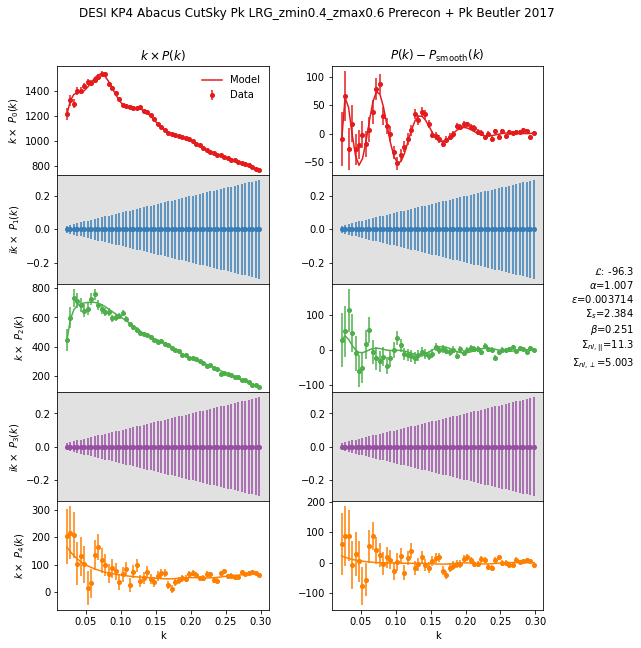

Using dataset <barry.datasets.dataset_correlation_function.CorrelationFunction_DESI_KP4 object at 0x15551caf3130>
Posterior -44.309 for defaults {'alpha': 1.0, 'epsilon': 0.0, 'sigma_s': 10.0, 'beta': 0.44371448205067143, 'sigma_nl_par': 8.0, 'sigma_nl_perp': 4.0, 'b{0}': 1.0, 'a{4}_3': 0.0, 'a{2}_2': 0.0, 'a{0}_1': 0.0, 'om': 0.30888871629127124, 'a{0}_3': 0.0, 'a{4}_1': 0.0, 'a{0}_2': 0.0, 'b{2}': 1.0, 'a{2}_1': 0.0, 'a{4}_2': 0.0, 'a{2}_3': 0.0, 'b{4}': 1.0}
Model posterior takes on average, 73.96 milliseconds
Starting model optimisation. This may take some time.
Model optimisation with value -41.862 has parameters are {'alpha': 1.0052076003553125, 'epsilon': -0.0053419797564907, 'sigma_s': 6.816755386548825, 'beta': 0.31060013743546994, 'sigma_nl_par': 0.029260941782577238, 'sigma_nl_perp': 4.716997996414725, 'b{0}': 1.0, 'a{4}_3': 0.0, 'a{2}_2': 0.0, 'a{0}_1': 0.0, 'om': 0.30888871629127124, 'a{0}_3': 0.0, 'a{4}_1': 0.0, 'a{0}_2': 0.0, 'b{2}': 1.0, 'a{2}_1': 0.0, 'a{4}_2': 0.0, 'a

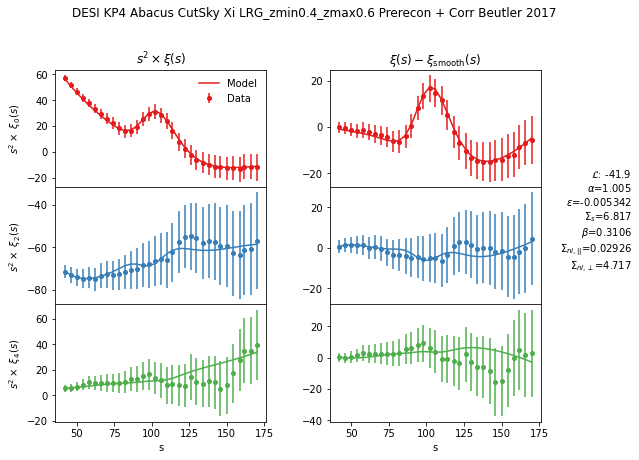

In [8]:
from barry.datasets.dataset_power_spectrum import PowerSpectrum_DESI_KP4
from barry.models.bao_power_Beutler2017 import PowerBeutler2017
from barry.datasets.dataset_correlation_function import CorrelationFunction_DESI_KP4
from barry.models.bao_correlation_Beutler2017 import CorrBeutler2017

# Load in the z=0.8-1.1 ezmock_cutsky dataset with and without the hexadecapole included in the fit
dataset = PowerSpectrum_DESI_KP4(mocktype="abacus_cutsky", realisation=0, fit_poles=(0,2,4), min_k=0.02, max_k=0.30, redshift_bin=1)

# A random selection of model choices
model_beutler = PowerBeutler2017(isotropic=False, poly_poles=(0,2,4), marg="full")

# All the previous functions ghet wrapped up into a convenient `sanity check` check
model_beutler.sanity_check(dataset)

# Load in the z=0.8-1.1 ezmock_cutsky dataset with and without the hexadecapole included in the fit
dataset = CorrelationFunction_DESI_KP4(mocktype="abacus_cutsky", realisation=0, fit_poles=(0,2,4), min_dist=40.0, max_dist=170.0, redshift_bin=1)

# A random selection of model choices
model_beutler = CorrBeutler2017(isotropic=False, poly_poles=(0,2,4), marg="full")

# All the previous functions ghet wrapped up into a convenient `sanity check` check
model_beutler.sanity_check(dataset)